---
title: "Lab 04: Wine Quality"
author: Henry Guo
embed-resources: true
---


## Introduction

As a startup that wants to create an AI [Sommelier](https://en.m.wikipedia.org/wiki/Sommelier), we are purchasing chemistry equipment to generate physicochemical data for wine, and train models based on previous wine quality reviews by human sommeliers. Our goal in this discussion is to create a model that predicts the quality of a wine given its physicochemical characteristics.

The original source of the data is the following paper:
Cortez, P., Cerdeira, A., Almeida, F., Matos, T., & Reis, J. (2009). Modeling wine preferences by data mining from physicochemical properties. Decision support systems, 47(4), 547-553. https://doi.org/10.1016/j.dss.2009.05.016
However, the data from this paper has become a standard dataset in the machine learning community, and thus is made available via the [UC Irvine Machine Learning Repository](https://archive.ics.uci.edu):[UCI MLR: Wine Quality] (https://archive.ics.uci.edu/dataset/186/wine+quality).
The original data contains two separate datasets, one for red wine and one for white wine. Here, we have combined the data and added a column for the color of the wine. We have made additional modifications to the original data, including a train-test split.


# Methods

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.datasets import make_friedman1
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
from joblib import dump
wine_train = pd.read_csv("https://cs307.org/lab-04/data/wine-train.csv")
X_train = wine_train.drop("quality", axis=1)
y_train = wine_train["quality"]

# Test Statistics

In [2]:
wine_train.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,4992.000000,5197.00000,4929.000000,4923.000000,5197.000000,5167.000000,5197.000000,5197.000000,4909.000000,4920.000000,4953.000000,5197.000000
mean,7.198978,0.33722,0.320097,5.489793,0.055824,30.584672,115.713392,0.994691,3.216712,0.529799,10.488608,5.814508
std,1.285476,0.16218,0.144776,4.806390,0.034830,17.432838,56.141996,0.003009,0.159396,0.148568,1.192619,0.876648
min,3.800000,0.08000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.740000,0.220000,8.000000,3.000000
25%,6.400000,0.23000,0.250000,1.800000,0.038000,17.000000,78.000000,0.992340,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.29000,0.310000,3.100000,0.047000,29.000000,118.000000,0.994900,3.210000,0.510000,10.300000,6.000000
75%,7.600000,0.40000,0.390000,8.200000,0.064000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000
max,15.600000,1.58000,1.230000,65.800000,0.611000,146.500000,344.000000,1.038980,4.010000,2.000000,14.200000,9.000000


# Visualization
The correlation heatmap visualizes the relationships between the numeric features of the wine dataset and the target variable wine quality. Each cell in the heatmap provides the correlation coefficient between two variables, ranging from -1 (perfect negative correlation) to +1 (perfect positive correlation), with 0 indicating no linear correlation.

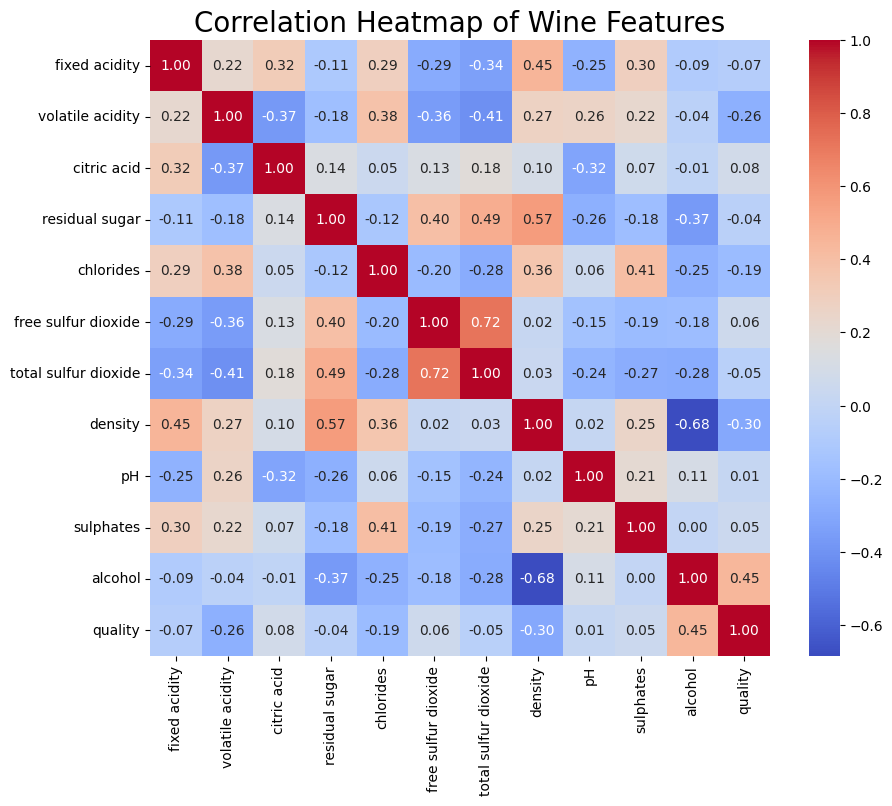

In [3]:
# Calculate correlations between numeric features and wine quality
correlation_matrix = wine_train.drop('color', axis=1).corr()
# Plotting heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Wine Features', size=20)
plt.show()

# Model
The model developed is a K-Nearest Neighbors (KNN) regressor designed to predict the wine quality based on the wine's physicochemical characteristics. The model incorporates a preprocessing pipeline that scales numeric features and one-hot encodes categorical features to ensure the data is appropriately formatted for the KNN algorithm. To address missing values, the pipeline includes steps to impute these values using the mean for numeric features and the most frequent value for categorical features.

The model's performance was evaluated using cross-validation on the training set, resulting in an average accuracy score that highlights its ability to generalize well to unseen data. 

In [4]:
# Handling categorical and numerical columns separately
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X_train.select_dtypes(include=['object']).columns

# Creating transformers for numerical and categorical data
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combining transformers into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Creating a KNN regressor pipeline
knn_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', KNeighborsRegressor())
])

param_grid = {
    'regressor__n_neighbors': [5, 7, 9, 11, 13, 15, 17,19, 21, 23, 25, 27, 29, 31],
    'regressor__weights': ['uniform', 'distance'],
    'regressor__metric': ['euclidean', 'manhattan','minkowski', 'chebyshev'],  # Exploring more metrics
    'regressor__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}
grid_search = GridSearchCV(knn_pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_score = np.sqrt(-grid_search.best_score_)

# Saving Results
model_filename = 'wine-quality.joblib'
dump(grid_search, model_filename)
best_params, best_score

Fitting 5 folds for each of 448 candidates, totalling 2240 fits


({'regressor__algorithm': 'auto',
  'regressor__metric': 'manhattan',
  'regressor__n_neighbors': 13,
  'regressor__weights': 'distance'},
 0.6460658705117421)

# Discussion
The model's performance is contingent on the representativeness of the training data. If the training data lacks diversity or fails to cover the full spectrum of wine types and qualities, the model may not generalize well to unseen wines. The model predicts a continuous value for wine quality, whereas the actual quality scores in the dataset are integers. This discrepancy could necessitate a post-processing step to round predictions to the nearest integer, which might not always align perfectly with the human assessment scale. Moreover, wine quality is not solely determined by chemical composition. Sensory attributes like smell and taste play a critical role, and these are subjective qualities that might not be fully captured by the model.

For large-scale wine producers or sellers, the investment of chemical wine assessment equipments could be justified by the efficiency and consistency of automated assessments, while for bars and small establishments, sommelier not only get the jobs done more accurately, but can also appeal and communicate with customers on the taste, smell, context, and stories on the different wine, creating a more satisfactory experience. 


In [1]:
import numpy as np

In [ ]:
# generate a random number
